In [1]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

train_df = pd.read_csv('D:/GBM project/train_labels.csv')

In [2]:
file_names = os.listdir('D:/GBM project/train_set')
filenames = [file_name.lstrip('0') for file_name in file_names[1:]]
filenames.insert(0, '0')

filenames = [int(filename) for filename in filenames]
# print(filenames)

In [3]:
i = []
for filename in filenames:
    i.append(train_df[train_df['BraTS21ID'] == int(filename)].index.tolist())
want_row = []
for num in i:
    want_row.append(num[0])
    
# print(want_row)

In [4]:
train_df = train_df.iloc[want_row]
train_df.reset_index(inplace=True, drop=True)
# train_df

In [5]:
# plt.figure(figsize = (5, 5))
# sns.countplot(data = train_df, x = 'MGMT_value')

In [6]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [7]:
from matplotlib import animation, rc
rc('animation', html='jshtml')


def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

In [8]:
def load_dicom_line(path):
    t_paths = sorted(
        glob.glob(os.path.join(path, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    images = []
    for filename in t_paths:
        data = load_dicom(filename)
        if data.max() == 0:
            continue
        images.append(data)
        
    return images

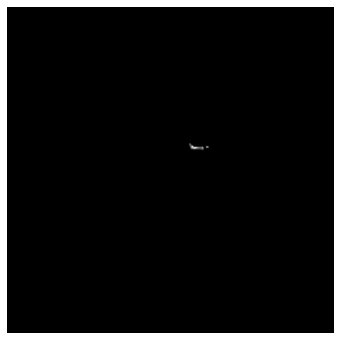

In [16]:
images = load_dicom_line("D:/GBM project/train_set/00002/T2w")
# create_animation(images)
anim = create_animation(images)

In [17]:
f = r"D:/GBM project/T2w.gif" 
writergif = animation.PillowWriter(fps=60) 
anim.save(f, writer=writergif)

In [76]:
import time

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import efficientnet_pytorch
import random
import glob

from sklearn.model_selection import StratifiedKFold

In [77]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

In [78]:
df = train_df
df_train, df_valid = sk_model_selection.train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)

In [79]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths, targets):
        self.paths = paths
        self.targets = targets
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = f"D:/GBM project/train_set/{str(_id).zfill(5)}/"
        channels = []
        for t in ("FLAIR", "T1w", "T1wCE"): # "T2w"
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            # start, end = int(len(t_paths) * 0.475), int(len(t_paths) * 0.525)
            x = len(t_paths)
            if x < 10:
                r = range(x)
            else:
                d = x // 10
                r = range(d, x - d, d)
                
            channel = []
            # for i in range(start, end + 1):
            for i in r:
                channel.append(cv2.resize(load_dicom(t_paths[i]), (256, 256)) / 255)
            channel = np.mean(channel, axis=0)
            channels.append(channel)
            
        y = torch.tensor(self.targets[index], dtype=torch.float)
        
        return {"X": torch.tensor(channels).float(), "y": y}

In [80]:
train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

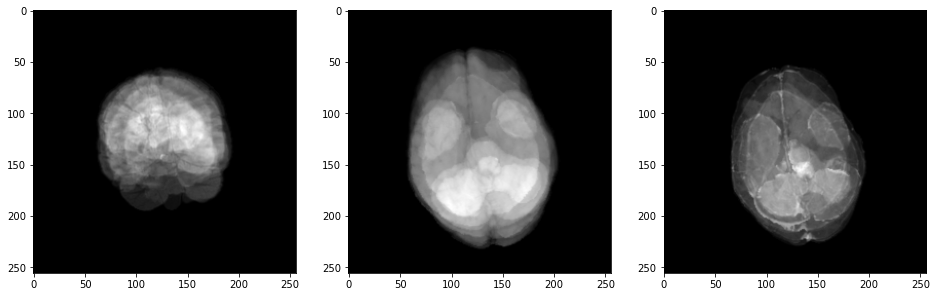

In [81]:
plt.figure(figsize=(16, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(train_data_retriever[2]["X"].numpy()[i], cmap="gray")

In [90]:
 class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = efficientnet_pytorch.EfficientNet.from_pretrained('efficientnet-b0')
        checkpoint = torch.load('D:/GBM project/best-model-0.pth', map_location=torch.device('cpu'))
        self.net.load_state_dict(checkpoint)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

In [91]:
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg

In [92]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        
        self.best_valid_score = -np.inf
        self.n_patience = 0
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )

            if True:
#             if self.best_valid_score < valid_score:
                self.info_message(
                    self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                )
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path)
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}'
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_retriever = DataRetriever(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
)

valid_data_retriever = DataRetriever(
    df_valid["BraTS21ID"].values, 
    df_valid["MGMT_value"].values,
)

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=8,
    shuffle=True,
    num_workers=8,
)

valid_loader = torch_data.DataLoader(
    valid_data_retriever, 
    batch_size=8,
    shuffle=False,
    num_workers=8,
)

model = Model()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch_functional.binary_cross_entropy_with_logits

trainer = Trainer(
    model, 
    device, 
    optimizer, 
    criterion, 
    LossMeter, 
    AccMeter
)

history = trainer.fit(
    10, 
    train_loader, 
    valid_loader, 
    f"best-model-0.pth", 
    100,
)

Loaded pretrained weights for efficientnet-b0


RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "_conv_stem.weight", "_bn0.weight", "_bn0.bias", "_bn0.running_mean", "_bn0.running_var", "_blocks.0._depthwise_conv.weight", "_blocks.0._bn1.weight", "_blocks.0._bn1.bias", "_blocks.0._bn1.running_mean", "_blocks.0._bn1.running_var", "_blocks.0._se_reduce.weight", "_blocks.0._se_reduce.bias", "_blocks.0._se_expand.weight", "_blocks.0._se_expand.bias", "_blocks.0._project_conv.weight", "_blocks.0._bn2.weight", "_blocks.0._bn2.bias", "_blocks.0._bn2.running_mean", "_blocks.0._bn2.running_var", "_blocks.1._expand_conv.weight", "_blocks.1._bn0.weight", "_blocks.1._bn0.bias", "_blocks.1._bn0.running_mean", "_blocks.1._bn0.running_var", "_blocks.1._depthwise_conv.weight", "_blocks.1._bn1.weight", "_blocks.1._bn1.bias", "_blocks.1._bn1.running_mean", "_blocks.1._bn1.running_var", "_blocks.1._se_reduce.weight", "_blocks.1._se_reduce.bias", "_blocks.1._se_expand.weight", "_blocks.1._se_expand.bias", "_blocks.1._project_conv.weight", "_blocks.1._bn2.weight", "_blocks.1._bn2.bias", "_blocks.1._bn2.running_mean", "_blocks.1._bn2.running_var", "_blocks.2._expand_conv.weight", "_blocks.2._bn0.weight", "_blocks.2._bn0.bias", "_blocks.2._bn0.running_mean", "_blocks.2._bn0.running_var", "_blocks.2._depthwise_conv.weight", "_blocks.2._bn1.weight", "_blocks.2._bn1.bias", "_blocks.2._bn1.running_mean", "_blocks.2._bn1.running_var", "_blocks.2._se_reduce.weight", "_blocks.2._se_reduce.bias", "_blocks.2._se_expand.weight", "_blocks.2._se_expand.bias", "_blocks.2._project_conv.weight", "_blocks.2._bn2.weight", "_blocks.2._bn2.bias", "_blocks.2._bn2.running_mean", "_blocks.2._bn2.running_var", "_blocks.3._expand_conv.weight", "_blocks.3._bn0.weight", "_blocks.3._bn0.bias", "_blocks.3._bn0.running_mean", "_blocks.3._bn0.running_var", "_blocks.3._depthwise_conv.weight", "_blocks.3._bn1.weight", "_blocks.3._bn1.bias", "_blocks.3._bn1.running_mean", "_blocks.3._bn1.running_var", "_blocks.3._se_reduce.weight", "_blocks.3._se_reduce.bias", "_blocks.3._se_expand.weight", "_blocks.3._se_expand.bias", "_blocks.3._project_conv.weight", "_blocks.3._bn2.weight", "_blocks.3._bn2.bias", "_blocks.3._bn2.running_mean", "_blocks.3._bn2.running_var", "_blocks.4._expand_conv.weight", "_blocks.4._bn0.weight", "_blocks.4._bn0.bias", "_blocks.4._bn0.running_mean", "_blocks.4._bn0.running_var", "_blocks.4._depthwise_conv.weight", "_blocks.4._bn1.weight", "_blocks.4._bn1.bias", "_blocks.4._bn1.running_mean", "_blocks.4._bn1.running_var", "_blocks.4._se_reduce.weight", "_blocks.4._se_reduce.bias", "_blocks.4._se_expand.weight", "_blocks.4._se_expand.bias", "_blocks.4._project_conv.weight", "_blocks.4._bn2.weight", "_blocks.4._bn2.bias", "_blocks.4._bn2.running_mean", "_blocks.4._bn2.running_var", "_blocks.5._expand_conv.weight", "_blocks.5._bn0.weight", "_blocks.5._bn0.bias", "_blocks.5._bn0.running_mean", "_blocks.5._bn0.running_var", "_blocks.5._depthwise_conv.weight", "_blocks.5._bn1.weight", "_blocks.5._bn1.bias", "_blocks.5._bn1.running_mean", "_blocks.5._bn1.running_var", "_blocks.5._se_reduce.weight", "_blocks.5._se_reduce.bias", "_blocks.5._se_expand.weight", "_blocks.5._se_expand.bias", "_blocks.5._project_conv.weight", "_blocks.5._bn2.weight", "_blocks.5._bn2.bias", "_blocks.5._bn2.running_mean", "_blocks.5._bn2.running_var", "_blocks.6._expand_conv.weight", "_blocks.6._bn0.weight", "_blocks.6._bn0.bias", "_blocks.6._bn0.running_mean", "_blocks.6._bn0.running_var", "_blocks.6._depthwise_conv.weight", "_blocks.6._bn1.weight", "_blocks.6._bn1.bias", "_blocks.6._bn1.running_mean", "_blocks.6._bn1.running_var", "_blocks.6._se_reduce.weight", "_blocks.6._se_reduce.bias", "_blocks.6._se_expand.weight", "_blocks.6._se_expand.bias", "_blocks.6._project_conv.weight", "_blocks.6._bn2.weight", "_blocks.6._bn2.bias", "_blocks.6._bn2.running_mean", "_blocks.6._bn2.running_var", "_blocks.7._expand_conv.weight", "_blocks.7._bn0.weight", "_blocks.7._bn0.bias", "_blocks.7._bn0.running_mean", "_blocks.7._bn0.running_var", "_blocks.7._depthwise_conv.weight", "_blocks.7._bn1.weight", "_blocks.7._bn1.bias", "_blocks.7._bn1.running_mean", "_blocks.7._bn1.running_var", "_blocks.7._se_reduce.weight", "_blocks.7._se_reduce.bias", "_blocks.7._se_expand.weight", "_blocks.7._se_expand.bias", "_blocks.7._project_conv.weight", "_blocks.7._bn2.weight", "_blocks.7._bn2.bias", "_blocks.7._bn2.running_mean", "_blocks.7._bn2.running_var", "_blocks.8._expand_conv.weight", "_blocks.8._bn0.weight", "_blocks.8._bn0.bias", "_blocks.8._bn0.running_mean", "_blocks.8._bn0.running_var", "_blocks.8._depthwise_conv.weight", "_blocks.8._bn1.weight", "_blocks.8._bn1.bias", "_blocks.8._bn1.running_mean", "_blocks.8._bn1.running_var", "_blocks.8._se_reduce.weight", "_blocks.8._se_reduce.bias", "_blocks.8._se_expand.weight", "_blocks.8._se_expand.bias", "_blocks.8._project_conv.weight", "_blocks.8._bn2.weight", "_blocks.8._bn2.bias", "_blocks.8._bn2.running_mean", "_blocks.8._bn2.running_var", "_blocks.9._expand_conv.weight", "_blocks.9._bn0.weight", "_blocks.9._bn0.bias", "_blocks.9._bn0.running_mean", "_blocks.9._bn0.running_var", "_blocks.9._depthwise_conv.weight", "_blocks.9._bn1.weight", "_blocks.9._bn1.bias", "_blocks.9._bn1.running_mean", "_blocks.9._bn1.running_var", "_blocks.9._se_reduce.weight", "_blocks.9._se_reduce.bias", "_blocks.9._se_expand.weight", "_blocks.9._se_expand.bias", "_blocks.9._project_conv.weight", "_blocks.9._bn2.weight", "_blocks.9._bn2.bias", "_blocks.9._bn2.running_mean", "_blocks.9._bn2.running_var", "_blocks.10._expand_conv.weight", "_blocks.10._bn0.weight", "_blocks.10._bn0.bias", "_blocks.10._bn0.running_mean", "_blocks.10._bn0.running_var", "_blocks.10._depthwise_conv.weight", "_blocks.10._bn1.weight", "_blocks.10._bn1.bias", "_blocks.10._bn1.running_mean", "_blocks.10._bn1.running_var", "_blocks.10._se_reduce.weight", "_blocks.10._se_reduce.bias", "_blocks.10._se_expand.weight", "_blocks.10._se_expand.bias", "_blocks.10._project_conv.weight", "_blocks.10._bn2.weight", "_blocks.10._bn2.bias", "_blocks.10._bn2.running_mean", "_blocks.10._bn2.running_var", "_blocks.11._expand_conv.weight", "_blocks.11._bn0.weight", "_blocks.11._bn0.bias", "_blocks.11._bn0.running_mean", "_blocks.11._bn0.running_var", "_blocks.11._depthwise_conv.weight", "_blocks.11._bn1.weight", "_blocks.11._bn1.bias", "_blocks.11._bn1.running_mean", "_blocks.11._bn1.running_var", "_blocks.11._se_reduce.weight", "_blocks.11._se_reduce.bias", "_blocks.11._se_expand.weight", "_blocks.11._se_expand.bias", "_blocks.11._project_conv.weight", "_blocks.11._bn2.weight", "_blocks.11._bn2.bias", "_blocks.11._bn2.running_mean", "_blocks.11._bn2.running_var", "_blocks.12._expand_conv.weight", "_blocks.12._bn0.weight", "_blocks.12._bn0.bias", "_blocks.12._bn0.running_mean", "_blocks.12._bn0.running_var", "_blocks.12._depthwise_conv.weight", "_blocks.12._bn1.weight", "_blocks.12._bn1.bias", "_blocks.12._bn1.running_mean", "_blocks.12._bn1.running_var", "_blocks.12._se_reduce.weight", "_blocks.12._se_reduce.bias", "_blocks.12._se_expand.weight", "_blocks.12._se_expand.bias", "_blocks.12._project_conv.weight", "_blocks.12._bn2.weight", "_blocks.12._bn2.bias", "_blocks.12._bn2.running_mean", "_blocks.12._bn2.running_var", "_blocks.13._expand_conv.weight", "_blocks.13._bn0.weight", "_blocks.13._bn0.bias", "_blocks.13._bn0.running_mean", "_blocks.13._bn0.running_var", "_blocks.13._depthwise_conv.weight", "_blocks.13._bn1.weight", "_blocks.13._bn1.bias", "_blocks.13._bn1.running_mean", "_blocks.13._bn1.running_var", "_blocks.13._se_reduce.weight", "_blocks.13._se_reduce.bias", "_blocks.13._se_expand.weight", "_blocks.13._se_expand.bias", "_blocks.13._project_conv.weight", "_blocks.13._bn2.weight", "_blocks.13._bn2.bias", "_blocks.13._bn2.running_mean", "_blocks.13._bn2.running_var", "_blocks.14._expand_conv.weight", "_blocks.14._bn0.weight", "_blocks.14._bn0.bias", "_blocks.14._bn0.running_mean", "_blocks.14._bn0.running_var", "_blocks.14._depthwise_conv.weight", "_blocks.14._bn1.weight", "_blocks.14._bn1.bias", "_blocks.14._bn1.running_mean", "_blocks.14._bn1.running_var", "_blocks.14._se_reduce.weight", "_blocks.14._se_reduce.bias", "_blocks.14._se_expand.weight", "_blocks.14._se_expand.bias", "_blocks.14._project_conv.weight", "_blocks.14._bn2.weight", "_blocks.14._bn2.bias", "_blocks.14._bn2.running_mean", "_blocks.14._bn2.running_var", "_blocks.15._expand_conv.weight", "_blocks.15._bn0.weight", "_blocks.15._bn0.bias", "_blocks.15._bn0.running_mean", "_blocks.15._bn0.running_var", "_blocks.15._depthwise_conv.weight", "_blocks.15._bn1.weight", "_blocks.15._bn1.bias", "_blocks.15._bn1.running_mean", "_blocks.15._bn1.running_var", "_blocks.15._se_reduce.weight", "_blocks.15._se_reduce.bias", "_blocks.15._se_expand.weight", "_blocks.15._se_expand.bias", "_blocks.15._project_conv.weight", "_blocks.15._bn2.weight", "_blocks.15._bn2.bias", "_blocks.15._bn2.running_mean", "_blocks.15._bn2.running_var", "_conv_head.weight", "_bn1.weight", "_bn1.bias", "_bn1.running_mean", "_bn1.running_var", "_fc.weight", "_fc.bias". 
	Unexpected key(s) in state_dict: "model_state_dict", "optimizer_state_dict", "best_valid_score", "n_epoch". 